# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


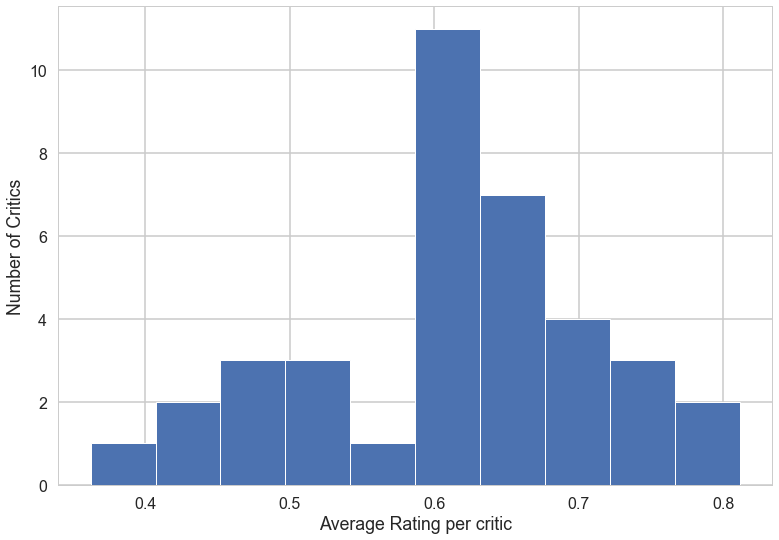

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The histogram is in an incomplete Gaussian model. The most common rating given by critics is in the ~0.6, which is interesting, since that means most of the time critics tend to like movies that they watched than not. The very low value before 0.6 means that critics tend to curve up to 0.6 instead of rating the critics into 0.56. 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [7]:
#your turn
## 1. split the data set into a training and test set
import sklearn
## 2. use scikit-learn's MultinomialNB() classifier with default parameters.
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.33, random_state = 5)
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(10425, 22417)
(5136, 22417)
(10425,)
(5136,)


/Users/tanggara/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
## 3. train the classifier over the training set and test on the test set
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)

y_train_predict=clf.predict(X_train)
Y_test_predict=clf.predict(X_test)

In [9]:
# 4. print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score

print('accuracy score for training set %.3f' % accuracy_score(y_train_predict, Y_train))
print('accuracy score for test set %.3f' % accuracy_score(Y_test_predict, Y_test))

accuracy score for training set 0.922
accuracy score for test set 0.774


What I noticed: the naive bayes classifier is really good with training set (0.922 accuracy), but did not do that well with the test set (0.774 accuracy). The classifier is adequate enough, but comparison with other algorithm is needed in order to make the determination whether this is a good classifier or not.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

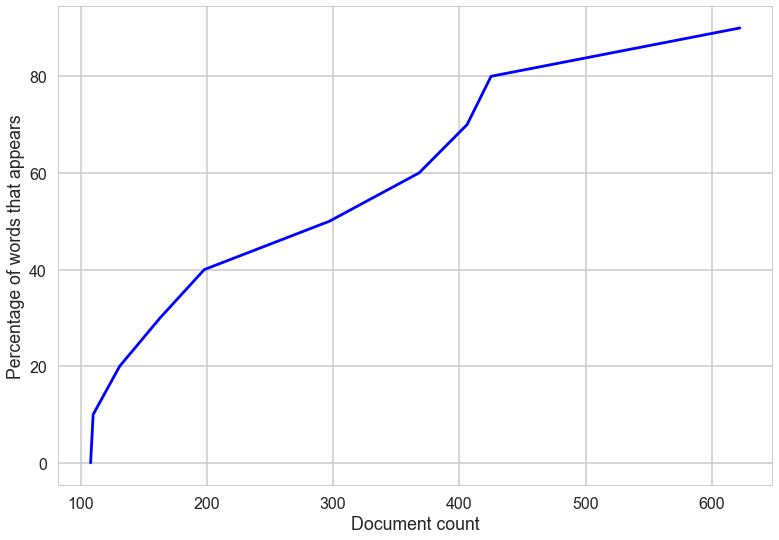

In [10]:
# Your turn.
values,base= np.histogram(means, bins=10)
cumulative = np.cumsum(values)
plt.plot(cumulative, base[:-1]*100 , c='blue')

plt.xlabel("Document count")
plt.ylabel("Percentage of words that appears")
#print cumulative
# print base
# http://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
#tick_spacing = 1
##fig, ax = plt.subplots(1,1)
#ax.plot(cumulative, base)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#plt.show()



The min_df will be **0** since the curved climbed steep since the very beginning. <br>
The max_df will be in the **425**.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [11]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [12]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [13]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

Exercise: What does using the function log_likelihood as the score mean? What are we trying to optimize for? <br>
<span style="color:blue">Answer: We are trying to optimize for the probability whether the review is fresh or rotten based on the alpha value (smoothing parameter) in the naive bayes algorithm.</span>

Exercise: Without writing any code, what do you think would happen if you choose a value of  $\alpha$  that is too high? <br>
<span style="color:blue">Answer: This resulted in the dependence on the alpha (smoothing parameter) and makes the model over-fit. </span>

Exercise: Using the skeleton code below, find the best values of the parameter alpha, and use the value of min_df you Echose in the previous exercise set. Use the cv_score function above with the log_likelihood function for scoring.

In [14]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 0 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn
    clfhyper = MultinomialNB(alpha=alpha).fit(Xtrainthis, ytrainthis)
    #scorefuncval = log_likelihood(clfhyper, Xtrainthis, ytrainthis)
    #print scorefuncval
    print('For alpha = %s, the cross validation score is %s') % (alpha,cv_score(clfhyper,Xtrainthis,ytrainthis,log_likelihood))

For alpha = 0.1, the cross validation score is -987.496186111
For alpha = 1, the cross validation score is -729.014571624
For alpha = 5, the cross validation score is -1203.80589384
For alpha = 10, the cross validation score is -1350.52655961
For alpha = 50, the cross validation score is -1320.07295262


$\alpha$ of 1 provides the highest cross validation score. We need to see whether that will result in overfitting or not from _Exercise Set V_. 

In [15]:
best_alpha=1
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [16]:
#print best_min_df
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]
#print(best_alpha)
clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.934676
Accuracy on test data:     0.737238


Not really, since the accuracy using this method (0.73) is slightly lower than the accuracy from our previous method (0.77). 

In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2058 2138]
 [ 724 5972]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [18]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
('             delight', '0.95')
('       extraordinary', '0.95')
('            touching', '0.94')
('           fashioned', '0.94')
('              superb', '0.94')
('          mainstream', '0.94')
('                 joy', '0.94')
('         imaginative', '0.93')
('            pleasant', '0.93')
('         beautifully', '0.93')
Bad words	     P(fresh | word)
('              tricks', '0.12')
('              mildly', '0.12')
('              cliche', '0.11')
('               sadly', '0.11')
('              unless', '0.09')
('             unfunny', '0.09')
('          uninspired', '0.09')
('                lame', '0.07')
('       unfortunately', '0.07')
('                save', '0.07')


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

This method work since we are sorting the words that is best represent the possibility of fresh and rotten review by the critics. <br>
The probability for each row in the identity matrix represents each features that are being considered as "good" or "bad" words.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [19]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

By its midpoint, however, Thornton has begun forcing both the film's poetry and the preternatural goodness of its simple-minded protagonist, and Sling Blade's sweet charms begin to curdle.

What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

Herzog offers some evidence of Kinski's great human warmth, somewhat more of his rage of unimaginable proportions, and a good demonstration of Kinski's uncanny capacity to corkscrew his way into the frame.

Cast of newcomers is appealing, but this small-town melodrama is so old-fashioned and out-of-touch with contemporary youth that it feels as if

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [49]:
#your turn
from sklearn.feature_extraction.text import CountVectorizer
text2 = ["This movie is not remarkable, touching, or superb in any way."]

vectorizer = CountVectorizer(min_df=0)
# call `fit` to build the vocabulary
vectorizer.fit(text2)
# call `transform` to convert text to a bag of words
x2 = vectorizer.transform(text2)
# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x2 = x2.toarray()

# http://stackoverflow.com/questions/41271725/getting-valueerror-shapes-not-aligned-on-scikit-linear-regression
test_encoded = pd.DataFrame(x2,columns=vectorizer.get_feature_names())
test_encoded_for_model = test_encoded.reindex(columns = words, 
    fill_value=0)
# print test_encoded_for_model.shape

# using the hyper-parameter tuning that I did earlier: best_min_df = 0, and alpha = 1
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
clf = MultinomialNB(alpha=1).fit(X, y)
print clf.predict(test_encoded_for_model)


[1]


The algorithm predicts that the sentence, "_This movie is not remarkable, touching, or superb in any way._" is fresh (a positive review). 

The result is what I would expect, the word "remarkable", "touching", and "superb" are associated with positive reviews and the only marks of negative review is "not" in this case. So, the algorithm failed to classify this particular sentence as a negative (rotten) review. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [50]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [51]:
# Your turn

### 1. Build a Naive Bayes model where the features are n-grams instead of words. We will use n=2 (bigrams) as an example.

In [53]:
def make_xy_bi(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer(ngram_range=(2,2))
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy_bi(critics)

In [56]:

## 1. split the data set into a training and test set

from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.33, random_state = 5)
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(10425, 152405)
(5136, 152405)
(10425,)
(5136,)


In [57]:
## 2. use scikit-learn's MultinomialNB() classifier with default parameters.
## 3. train the classifier over the training set and test on the test set
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)

y_train_predict=clf.predict(X_train)
Y_test_predict=clf.predict(X_test)

In [58]:
# 4. print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score

print('accuracy score for training set %.3f' % accuracy_score(y_train_predict, Y_train))
print('accuracy score for test set %.3f' % accuracy_score(Y_test_predict, Y_test))

accuracy score for training set 0.995
accuracy score for test set 0.693


### 2. Try a model besides Naive Bayes: a Random Forest classifier.

In [64]:
X, y = make_xy(critics)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.33, random_state = 5)


from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, #10 decision trees
                                random_state=1,
                                n_jobs=2) # parallelization parameter
forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [65]:
y_train_predict_rf=forest.predict(X_train)
Y_test_predict_rf=forest.predict(X_test)
# 4. print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score

print('accuracy score for training set %.3f' % accuracy_score(y_train_predict_rf, Y_train))
print('accuracy score for test set %.3f' % accuracy_score(Y_test_predict_rf, Y_test))

accuracy score for training set 0.992
accuracy score for test set 0.694


### 3. Use TF-IDF weighting instead of word counts.

In [66]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
Xtfidf = Xtfidf.tocsc()
y = (critics.fresh == 'fresh').values.astype(np.int)

In [67]:
## 1. split the data set into a training and test set

X_train, X_test, Y_train, Y_test = train_test_split(
    Xtfidf, y, test_size=0.33, random_state = 5)

## 2. use scikit-learn's MultinomialNB() classifier with default parameters.
## 3. train the classifier over the training set and test on the test set

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)

y_train_predict=clf.predict(X_train)
Y_test_predict=clf.predict(X_test)

# 4. print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score

print('accuracy score for training set %.3f' % accuracy_score(y_train_predict, Y_train))
print('accuracy score for test set %.3f' % accuracy_score(Y_test_predict, Y_test))


accuracy score for training set 0.843
accuracy score for test set 0.713


### 4. Use word2vec or Latent Dirichlet Allocation to group words into topics and use those topics for prediction.

#### word2vec

In [192]:
#https://markroxor.github.io/gensim/tutorials/index.html
from gensim.models import word2vec
from gensim import corpora

In [276]:
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb
docs = critics.quote
#type(docs)
listdocs=docs.tolist()
#type(listdocs)

In [277]:
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(listdocs)):
    listdocs[idx] = listdocs[idx].lower()  # Convert to lowercase.
    listdocs[idx] = tokenizer.tokenize(listdocs[idx])  # Split into words.

# Remove words that are only one character.
listdocs = [[token for token in doc if len(token) > 1] for doc in listdocs]
len(listdocs)
#listdocs

15561

In [278]:
from stop_words import get_stop_words
en_stop = get_stop_words('en')
en_stop.append("it")
en_stop.append("and")
en_stop.append("to")
en_stop.append("is")
en_stop.append("of")
en_stop.append("that")
en_stop.append("in")
en_stop.append("for")
en_stop.append("this")
en_stop.append("with")
en_stop.append("be")
en_stop.append("about")
en_stop.append("at")
en_stop.append("ll")
en_stop.append("le")
en_stop.append("ve")
en_stop.append("don")
en_stop.append("won")
en_stop.append("won")
en_stop.append("hasn")
en_stop.append("doesn")

listdocs = [[token for token in doc if token not in en_stop] for doc in listdocs]
#len(listdocs)
# listdocs

In [279]:
# Lemmatize the documents.

from nltk.stem.wordnet import WordNetLemmatizer

# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
listdocs = [[lemmatizer.lemmatize(token) for token in doc] for doc in listdocs]

In [280]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(listdocs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2017-04-29 18:35:06,836 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-04-29 18:35:07,215 : INFO : adding document #10000 to Dictionary(16723 unique tokens: [u'fawn', u'aided', u'finessed', u'raining', u'kidnaper']...)
2017-04-29 18:35:07,374 : INFO : built Dictionary(20092 unique tokens: [u'fawn', u'aided', u'finessed', u'daftness', u'raining']...) from 15561 documents (total 175802 corpus positions)
2017-04-29 18:35:07,423 : INFO : discarding 18505 tokens: [(u'postage', 2), (u'execution', 17), (u'stamp', 10), (u'sized', 4), (u'engulfed', 1), (u'spectrum', 3), (u'1995', 9), (u'catalog', 1), (u'hyperrealist', 1), (u'revived', 1)]...
2017-04-29 18:35:07,424 : INFO : keeping 1587 tokens which were in no less than 20 and no more than 7780 (=50.0%) documents
2017-04-29 18:35:07,439 : INFO : resulting dictionary: Dictionary(1587 unique tokens: [u'limited', u'suspenseful', u'four', u'woody', u'hate']...)


In [281]:
# Vectorize data.

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in listdocs]

In [282]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1587
Number of documents: 15561


#### LDA:  Latent Dirichlet Allocation 

In [284]:
# Train LDA model.

from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

2017-04-29 18:36:55,207 : INFO : using autotuned alpha, starting with [0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.10000000000000001]
2017-04-29 18:36:55,209 : INFO : using serial LDA version on this node
2017-04-29 18:36:55,339 : INFO : running online LDA training, 10 topics, 20 passes over the supplied corpus of 15561 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2017-04-29 18:36:55,340 : INFO : PROGRESS: pass 0, at document #2000/15561
2017-04-29 18:36:57,611 : INFO : optimized alpha [0.086651384353497202, 0.080836744788645581, 0.082233837414164485, 0.086493712096758504, 0.083237415904592521, 0.09043952319859716, 0.082671410295675887, 0.083673224162758159, 0.085090288834681699, 0.086260434803264438]
2017-04-29 18:36:57,612 : INFO : merg

CPU times: user 3min 18s, sys: 2.14 s, total: 3min 20s
Wall time: 3min 25s


In [285]:
top_topics = model.top_topics(corpus, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -760.5189.
[([(0.081558601911536341, u'movie'),
   (0.024458263666280389, u'make'),
   (0.021624006207630629, u'good'),
   (0.020313853059281475, u'time'),
   (0.020074349306496538, u'can'),
   (0.018741417859002112, u'much'),
   (0.016989455899796668, u'even'),
   (0.016860577327006722, u'character'),
   (0.015901385734913238, u'just'),
   (0.01448456841774747, u'story'),
   (0.014011182007803082, u'way'),
   (0.013472360391952674, u'well'),
   (0.012655396625145315, u'like'),
   (0.012196557656963722, u'never'),
   (0.011647225347254866, u'little'),
   (0.011361960078789446, u'get'),
   (0.011118656582449838, u'enough'),
   (0.010180153650472108, u'thing'),
   (0.009900359342432918, u'look'),
   (0.0094916078231926503, u'two')],
  -633.23614609628839),
 ([(0.13665861204234603, u'film'),
   (0.073010816625679473, u'one'),
   (0.036133039338037874, u'best'),
   (0.026753040990850737, u'made'),
   (0.026295655267414984, u'picture'),
   (0.023312951785330979, u'y

In [275]:
# http://brandonrose.org/clustering#Latent-Dirichlet-Allocation
#topics_matrix = model.show_topics(formatted=False, num_words=20)
#for i in topics_matrix:
#    print([str(word) for word in i])
#    print()

In [286]:
print(model.print_topics(num_topics=10, num_words=3))

2017-04-29 18:40:59,045 : INFO : topic #0 (1.009): 0.043*"performance" + 0.036*"like" + 0.030*"u"
2017-04-29 18:40:59,047 : INFO : topic #1 (0.554): 0.095*"comedy" + 0.071*"funny" + 0.053*"action"
2017-04-29 18:40:59,048 : INFO : topic #2 (0.517): 0.036*"effect" + 0.029*"self" + 0.024*"classic"
2017-04-29 18:40:59,049 : INFO : topic #3 (0.453): 0.054*"thriller" + 0.047*"entertaining" + 0.037*"high"
2017-04-29 18:40:59,051 : INFO : topic #4 (0.573): 0.045*"fun" + 0.036*"humor" + 0.033*"sense"
2017-04-29 18:40:59,052 : INFO : topic #5 (1.051): 0.034*"will" + 0.030*"life" + 0.027*"new"
2017-04-29 18:40:59,053 : INFO : topic #6 (0.506): 0.041*"mr" + 0.040*"cast" + 0.033*"part"
2017-04-29 18:40:59,055 : INFO : topic #7 (0.739): 0.062*"director" + 0.032*"without" + 0.020*"script"
2017-04-29 18:40:59,056 : INFO : topic #8 (2.602): 0.082*"movie" + 0.024*"make" + 0.022*"good"
2017-04-29 18:40:59,058 : INFO : topic #9 (1.219): 0.137*"film" + 0.073*"one" + 0.036*"best"


[(0, u'0.043*"performance" + 0.036*"like" + 0.030*"u"'), (1, u'0.095*"comedy" + 0.071*"funny" + 0.053*"action"'), (2, u'0.036*"effect" + 0.029*"self" + 0.024*"classic"'), (3, u'0.054*"thriller" + 0.047*"entertaining" + 0.037*"high"'), (4, u'0.045*"fun" + 0.036*"humor" + 0.033*"sense"'), (5, u'0.034*"will" + 0.030*"life" + 0.027*"new"'), (6, u'0.041*"mr" + 0.040*"cast" + 0.033*"part"'), (7, u'0.062*"director" + 0.032*"without" + 0.020*"script"'), (8, u'0.082*"movie" + 0.024*"make" + 0.022*"good"'), (9, u'0.137*"film" + 0.073*"one" + 0.036*"best"')]


In [ ]:
# some more readings:
# https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
# http://brandonrose.org/clustering#Latent-Dirichlet-Allocation

In [287]:
# Train LDA model.
# Second iteration

from gensim.models import LdaModel

# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model2 = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

2017-04-29 18:43:42,060 : INFO : using autotuned alpha, starting with [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
2017-04-29 18:43:42,062 : INFO : using serial LDA version on this node
2017-04-29 18:43:42,147 : INFO : running online LDA training, 8 topics, 20 passes over the supplied corpus of 15561 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2017-04-29 18:43:42,148 : INFO : PROGRESS: pass 0, at document #2000/15561
2017-04-29 18:43:44,541 : INFO : optimized alpha [0.10141257496187904, 0.099793062121448811, 0.10133733334750143, 0.10056840824408836, 0.10005778684530739, 0.10562379353968454, 0.10052518639672703, 0.10158495949985023]
2017-04-29 18:43:44,543 : INFO : merging changes from 2000 documents into a model of 15561 documents
2017-04-29 18:43:44,546 : INFO : topic #1 (0.100): 0.022*"movie" + 0.012*"one" + 0.011*"much" + 0.010*"like" + 0.010*"something" + 0.007*"mak

CPU times: user 3min 38s, sys: 2.41 s, total: 3min 40s
Wall time: 3min 50s


In [289]:
print(model2.print_topics(num_topics=10, num_words=3))

2017-04-29 18:49:07,819 : INFO : topic #0 (1.199): 0.026*"director" + 0.023*"film" + 0.020*"way"
2017-04-29 18:49:07,820 : INFO : topic #1 (0.512): 0.043*"picture" + 0.026*"effect" + 0.023*"style"
2017-04-29 18:49:07,822 : INFO : topic #2 (0.980): 0.037*"good" + 0.021*"enough" + 0.020*"fun"
2017-04-29 18:49:07,823 : INFO : topic #3 (0.863): 0.040*"comedy" + 0.025*"action" + 0.022*"thriller"
2017-04-29 18:49:07,824 : INFO : topic #4 (0.746): 0.043*"best" + 0.039*"performance" + 0.032*"well"
2017-04-29 18:49:07,825 : INFO : topic #5 (0.560): 0.032*"little" + 0.027*"something" + 0.021*"find"
2017-04-29 18:49:07,826 : INFO : topic #6 (0.427): 0.050*"year" + 0.038*"old" + 0.031*"minute"
2017-04-29 18:49:07,828 : INFO : topic #7 (1.618): 0.072*"movie" + 0.052*"film" + 0.039*"one"


[(0, u'0.026*"director" + 0.023*"film" + 0.020*"way"'), (1, u'0.043*"picture" + 0.026*"effect" + 0.023*"style"'), (2, u'0.037*"good" + 0.021*"enough" + 0.020*"fun"'), (3, u'0.040*"comedy" + 0.025*"action" + 0.022*"thriller"'), (4, u'0.043*"best" + 0.039*"performance" + 0.032*"well"'), (5, u'0.032*"little" + 0.027*"something" + 0.021*"find"'), (6, u'0.050*"year" + 0.038*"old" + 0.031*"minute"'), (7, u'0.072*"movie" + 0.052*"film" + 0.039*"one"')]


In [290]:
top_topics2 = model2.top_topics(corpus, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence2 = sum([t[1] for t in top_topics2]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence2)

from pprint import pprint
pprint(top_topics2)

Average topic coherence: -731.1582.
[([(0.025551084868716718, u'director'),
   (0.022653378341318267, u'film'),
   (0.019593032600765437, u'way'),
   (0.018451513383384584, u'life'),
   (0.018196849245824133, u'time'),
   (0.017662483103379967, u'movie'),
   (0.017485221851444386, u'much'),
   (0.016929113843226169, u'u'),
   (0.016598398527338767, u'take'),
   (0.015018701815138548, u'feel'),
   (0.014220588545345997, u'get'),
   (0.013308454509743552, u'real'),
   (0.012771633969759456, u'like'),
   (0.012036178497069512, u'give'),
   (0.011954188592726088, u're'),
   (0.011805061988801172, u'come'),
   (0.010268026772004562, u'make'),
   (0.010010987777210054, u'might'),
   (0.0097476102515599988, u'sense'),
   (0.0094685923022722347, u'character')],
  -632.78381874068327),
 ([(0.072036641386511113, u'movie'),
   (0.052286668892367855, u'film'),
   (0.038755902002202199, u'one'),
   (0.024517664894371266, u'can'),
   (0.021137818891235866, u'make'),
   (0.020239649847570179, u'like'